<a href="https://colab.research.google.com/github/nedokormysh/NLP_Fontanka/blob/main/Pymagic_scraping_parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
# !pip install selenium

Хотим спарсить новостные данные с сайта fontanka.ru

In [2]:
import re
import time
# import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
# from selenium import webdriver
# from selenium.webdriver.common.by import By
from dataclasses import dataclass
import requests
from datetime import datetime, date, timedelta
import logging
import sys

import asyncio
import aiohttp
from datetime import date, timedelta

In [3]:
logger = logging.getLogger(__name__)
handler = logging.StreamHandler(sys.stdout)
logger.setLevel(logging.INFO) #DEBUG
logger.addHandler(handler)
logger.propagate = False

if not logger.hasHandlers():
        logger.addHandler(logger)

Будем пробегать по датам в архиве сайта fontanka.ru. Не будем брать longreads, т.к. это зачастую рекламные записи. В основную функцию будем посылать дату с какого по какое число мы хотим забрать новости.

In [4]:
def parse_date(date_string):
    '''
    Функция для парсинга даты
    '''
    month_map = {
        'января': '01',
        'февраля': '02',
        'марта': '03',
        'апреля': '04',
        'мая': '05',
        'июня': '06',
        'июля': '07',
        'августа': '08',
        'сентября': '09',
        'октября': '10',
        'ноября': '11',
        'декабря': '12'
    }
    try:
        day, month_word, year, time = date_string.split(' ')
        # print(day, month_word, year, time)
        year = year.replace(',', '')
        month = month_map[month_word]
        formatted_date = f"{day}.{month}.{year} {time}"
        # print(formatted_date)
        return datetime.strptime(formatted_date, '%d.%m.%Y %H:%M')
    except Exception as e:
        print(f"Не удалось разобрать дату: {date_string}, ошибка: {e}")
        return None

In [5]:
def collect_data_from_page(url):
    print(f"Start collecting data for {url}")
    info = []

    try:
        response = requests.get(url)
        tree = BeautifulSoup(response.content, 'html.parser')
        # print(tree)
        articles = tree.find_all('li', {'class': 'IFae9'})

        # for article in tqdm(articles):
        for article in (articles):
            logger.debug('art', article)
            topic = article.find_all('a', {'class': 'IFhf IFkp'})
            subclass = article.find_all('a', {'class': 'IFcb'})
            logger.debug('sub', subclass)

            # не будем смотреть новости, у которых нет темы
            if len(topic) == 0:
                continue
            # забираем тему нашей статьи
            topic = topic[0].get('title')
            logger.debug('top', topic)

            # не будем использовать рекламные статьи
            if 'Афиша Plus' in topic:
                continue

            # забираем название
            title = subclass[0].text
            logger.debug('tit', title)

            suburl = subclass[0].get('href')

            if 'longreads' in suburl \
                or 'doctorpiter' in suburl \
                or 'https' in suburl \
                or 'vk' in suburl \
                or 'amp' in suburl:
                continue

            # переходим на страницу нашей статьи
            suburl = 'https://www.fontanka.ru'+ suburl

            response_inner = requests.get(suburl)
            tree_inner = BeautifulSoup(response_inner.content, 'html.parser')

            logger.debug(suburl)

            check_add = tree_inner.find_all('span', {'class': 'JBahp primarySubtitle1AccentMobile'})
            logger.debug('check_add', len(check_add))

            # не будем использовать рекламные статьи - у них нет секции
            # комментариев

            if len(check_add) == 0:
                continue

            content_ = tree_inner.find_all('div', {'class': 'B1ah I-a3 I-ah'})
            # logger.debug(content_)

            content_txt = []
            [content_txt.append(el.text) for el in content_]

            content = ' '.join(content_txt)
            views = int(tree_inner.find_all('span',\
                              {'class': 'A7hp primaryOverlineMobile'})[0].text)
            date_time = tree_inner.find_all('span', \
                              {'itemprop': 'datePublished'})[0].text

            date_time = parse_date(date_time)

            comments = int(tree_inner.find_all('span',
             {'class': 'JBahp primarySubtitle1AccentMobile'})[0].text)
            logger.debug('com', comments)

            row = {'url': suburl,
                   'title': title,
                   'content': content,
                   'topic': topic,
                   'datetime': date_time,
                   'views': views,
                   'comments_amount': comments}

            info.append(row)

        return info

    except requests.RequestException as e:
        # Сокращенное сообщение об ошибке
        print(f"Ошибка при получении данных со страницы {url}: \
                             {e.response.status_code} {e.response.reason}")
        return None

In [6]:
# df_ = pd.DataFrame(collect_data_from_page('https://www.fontanka.ru/2022/12/01/news.html'))

In [7]:
def main():
    i = 0

    # пустой датафрейм, в который будем сохранять результаты
    df_main = pd.DataFrame()

    # задаём даты начала и конца обработки
    start = date(2022, 11, 29)
    finish = date(2022, 12, 1)

    base_url = 'https://www.fontanka.ru/'
    info = []

    start_time = time.time()
    for day in tqdm(range((finish - start).days)):
        i += 1

        # Добавляем случайную задержку
        wait_time =  0 + np.random.choice([1, 2])
        print(f" Добавляем {wait_time} секунд перед обработкой следующей страницы")
        time.sleep(wait_time)

        particular_date = (start + timedelta(days=day)).strftime('%Y/%m/%d')
        url = f'{base_url}{particular_date}/news.html'
        # logger.debug(url)
        df_ = pd.DataFrame(collect_data_from_page(url))
        frames = [df_main, df_]
        logger.info(f'За {particular_date} день мы добавили {df_.shape[0]} запись(-ей)')
        df_main = pd.concat(frames)

        print(f'Всего у нас {df_main.shape[0]} записей')

        if i % 15 == 0:
            df_main.to_csv('fontanka_12-1.csv', index=False)
            print(f'Сохранились!')

    stop_time = time.time()
    all_time = stop_time - start_time
    ty_res = time.gmtime(all_time)


    print(f'На обработку {i} страницы(-иц) ушло \
    {time.strftime("%H:%M:%S", ty_res)} времени')

    return df_main


if __name__ == '__main__':
    res = main()
    res.to_csv('fontanka_full_12.csv', index=False)

  0%|          | 0/2 [00:00<?, ?it/s]

 Добавляем 2 секунд перед обработкой следующей страницы
Start collecting data for https://www.fontanka.ru/2022/11/29/news.html
За 2022/11/29 день мы добавили 76 запись(-ей)


 50%|█████     | 1/2 [02:07<02:07, 127.18s/it]

Всего у нас 76 записей
 Добавляем 1 секунд перед обработкой следующей страницы
Start collecting data for https://www.fontanka.ru/2022/11/30/news.html
За 2022/11/30 день мы добавили 75 запись(-ей)


100%|██████████| 2/2 [04:05<00:00, 122.97s/it]

Всего у нас 151 записей
На обработку 2 страницы(-иц) ушло     00:04:05 времени


In [8]:
df = pd.read_csv('/content/fontanka_full_12.csv')

In [9]:
df.head()

,url,title,content,topic,datetime,views,comments_amount
0,https://www.fontanka.ru/2022/11/29/71856143/,Впервые в истории главным арбитром матча мужск...,Француженка Стефани Фраппар станет первой в ми...,Спорт,2022-11-29 23:32:00,6445,15
1,https://www.fontanka.ru/2022/11/29/71856137/,После кухонного пожара житель Кронштадта попал...,В Кронштадте меньше получаса тушили трехкомнат...,Происшествия,2022-11-29 23:15:00,4163,1
2,https://www.fontanka.ru/2022/11/29/71856113/,Смятые машины и сломанное ограждение. В Петерб...,Вечер вторника в Петербурге оказался богат на ...,Происшествия,2022-11-29 22:57:00,19280,16
3,https://www.fontanka.ru/2022/11/29/71856128/,В полиции рассказали о состоянии сбитой на Пол...,"Женщина, которую сбили на пешеходном переходе ...",Происшествия,2022-11-29 22:37:00,11071,3
4,https://www.fontanka.ru/2022/11/29/71856116/,Правительство РФ запретило поставлять в недруж...,Правительство России установило запрет на выво...,Общество,2022-11-29 22:17:00,5546,18


К сожалению, разметка страниц достаточно часто меняется, возможно код, который работал 02.05.2024 уже не является актуальным.
Также для получения данных за год не использовался код, приведённый выше. Была написана асинхронная реализация

# Асинхронная реализация

Данные собирались за 2 года: 2022 и 2023

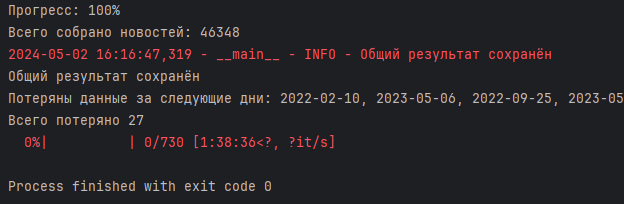

Реализована в скрипте [parsing.py](https://github.com/nedokormysh/NLP_Fontanka/blob/main/parsing/parsing.py). Код скрипта приведён ниже.




In [ ]:
import asyncio
import aiohttp
import pandas as pd
from bs4 import BeautifulSoup
import logging
from datetime import datetime, date, timedelta
from tqdm.asyncio import tqdm
import random
import aioconsole
from typing import Optional, NoReturn, List, Dict

# создаём логгер
logger = logging.getLogger(__name__)

# Настраиваем вывод логов в консоль
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
logger.addHandler(console_handler)

# Настраиваем вывод логов в файл
file_handler = logging.FileHandler('my_log_file.log')
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
logger.addHandler(file_handler)

# Устанавливаем уровень логирования для логгера
logger.setLevel(logging.DEBUG)


def parse_date(date_string: str) -> Optional[datetime]:
    """
    Функция парсинга даты из строкового представления
    :param date_string: строка с датой
    :return: datetime представление даты
    """
    logger.debug('Парсинг даты')

    month_map = {
        'января': '01',
        'февраля': '02',
        'марта': '03',
        'апреля': '04',
        'мая': '05',
        'июня': '06',
        'июля': '07',
        'августа': '08',
        'сентября': '09',
        'октября': '10',
        'ноября': '11',
        'декабря': '12'
    }
    try:
        day, month_word, year, time = date_string.split(' ')
        year = year.replace(',', '')
        month = month_map[month_word]
        formatted_date = f"{day}.{month}.{year} {time}"
        return datetime.strptime(formatted_date, '%d.%m.%Y %H:%M')
    except Exception as e:
        print(f"Не удалось разобрать дату: {date_string}, ошибка: {e}")
        logger.error(f"Не удалось разобрать дату: {date_string}")
        return None


async def print_progress(progress: int) -> NoReturn:
    """
    Функция печати прогресса в консоль
    :param progress: текущий прогресс в процентах
    :return: None
    """
    try:
        await aioconsole.aprint(f"\rПрогресс: {progress}%", end="")
    except Exception as e:
        # logger.debug(f"Ошибка при печати прогресса: {e}")
        logger.error(f"Ошибка при печати прогресса: {e}")


async def collect_data_from_page(url: str, semaphore: asyncio.Semaphore) -> List[Dict]:
    """
    Функция сбора данных с новостной страницы
    :param url: URL страницы
    :param semaphore: семафор для ограничения количества одновременных запросов
    :return: список словарей с данными о новостях
    """
    logger.info(f"Старт сбора данных для {url}")
    async with (aiohttp.ClientSession() as session):
        async with semaphore:
            try:
                async with session.get(url) as response:
                    html = await response.text()
                    tree = BeautifulSoup(html, 'html.parser')
                    articles = tree.find_all('li', {'class': 'IFae9'})
                    info = []
                    for article in articles:
                        topic = article.find_all('a', {'class': 'IFhf IFkp'})
                        subclass = article.find_all('a', {'class': 'IFcb'})

                        if len(topic) == 0:
                            continue
                        topic = topic[0].get('title')

                        # не берём некоторые темы, т.к. они рекламные
                        topics_to_skip = ['Афиша Plus',
                                          'Новости компаний',
                                          'Работа',
                                          'ЖКХ',
                                          'Финляндия']
                        if any(topic in topic_to_skip for topic_to_skip in topics_to_skip):
                            continue

                        title = subclass[0].text
                        suburl = subclass[0].get('href')

                        substrings_to_check = ['longreads', 'doctorpiter', 'https', 'vk', 'amp']
                        # не будем брать лонгриды и статьи с переходом на другие сайты
                        if any(substring in suburl for substring in substrings_to_check):
                            continue

                        suburl = 'https://www.fontanka.ru' + suburl

                        async with session.get(suburl) as response_inner:
                            html_inner = await response_inner.text()
                            tree_inner = BeautifulSoup(html_inner, 'html.parser')
                            check_add = tree_inner.find_all('span',
                                                            {'class': 'JBahp primarySubtitle1AccentMobile'})
                            if len(check_add) == 0:
                                continue
                            content_ = tree_inner.find_all('div', {'class': 'B1ah I-a3 I-ah'})
                            content_txt = []
                            [content_txt.append(el.text) for el in content_]
                            content = ' '.join(content_txt)
                            views = int(tree_inner.find_all('span',
                                                            {'class': 'A7hp primaryOverlineMobile'})[0].text)
                            date_time = tree_inner.find_all('span', {'itemprop': 'datePublished'})[0].text
                            date_time = parse_date(date_time)
                            comments = int(
                                tree_inner.find_all('span',
                                                    {'class': 'JBahp primarySubtitle1AccentMobile'})[0].text)
                            row = {'url': suburl,
                                   'title': title,
                                   'content': content,
                                   'topic': topic,
                                   'datetime': date_time,
                                   'views': views,
                                   'comments_amount': comments}
                            info.append(row)
                    logger.info(f"Данные для {url} собраны")
                    await asyncio.sleep(random.uniform(1, 3))
                    return info
            except Exception as e:
                # logger.info(f"Ошибка при сборе данных для {url}: {e}")
                logger.error(f"Ошибка при сборе данных для {url}: {e}")
                return []


async def main() -> NoReturn:
    """
    Функция выполняет сбор данных с новостных страниц и сохраняет их в CSV-файл
    """
    # пустой датафрейм, в который будем сохранять результаты
    df_main = pd.DataFrame()
    logger.info('Поехали')

    # задаём даты начала и конца обработки
    start = date(2022, 1, 1)
    finish = date(2024, 1, 1)

    # создаём список дат в диапазоне от start до finish
    dates = [start + timedelta(days=i) for i in range((finish - start).days)]

    # создаём список URL-адресов на основе списка дат
    urls = ['https://www.fontanka.ru/{}/news.html'.format(date.strftime('%Y/%m/%d')) for date in dates]

    semaphore = asyncio.Semaphore(10)  # Ограничиваем количество одновременных запросов

    # создаём список тасков для асинхронного выполнения
    tasks = [asyncio.create_task(collect_data_from_page(url, semaphore)) for url in urls]

    # Создаём экземпляр tqdm с общей длиной задач
    progress_bar = tqdm(total=len(tasks))

    try:

        results = []
        total_news = 0
        intermediate_df = pd.DataFrame()
        intermediate_count = 0  # подсчёт промежуточных значений
        intermediate_file_index = 0  # индексирование промежуточных значений
        for i, task in enumerate(asyncio.as_completed(tasks)):
            try:
                result = await task
                results.append(result)
                total_news += len(result)
                intermediate_df = pd.concat([intermediate_df, pd.DataFrame(result)])
                intermediate_count += len(result)
                if intermediate_count >= 1000:
                    # сохраняем промежуточный датафрейм в файл
                    intermediate_df.to_csv(f'fontanka_intermediate_{intermediate_file_index}.csv',
                                           index=False)
                    intermediate_df = pd.DataFrame()
                    intermediate_count = 0
                    intermediate_file_index += 1
            except aiohttp.client_exceptions.ServerDisconnectedError:
                print("Сервер отключился, пропускаем этот URL")
            progress = int(100 * (i + 1) / len(tasks))
            await print_progress(progress)  # выводим в консоль процент обработки

        print(f"\nВсего собрано новостей: {total_news}")

        # Сохраняем последний промежуточный результат, если там что-то есть.
        if not intermediate_df.empty:
            intermediate_df.to_csv(f'fontanka_intermediate_{intermediate_file_index}.csv', index=False)

        try:
            df_main = pd.concat([pd.DataFrame(result) for result in results])

            # сохраняем результаты в файл
            df_main.to_csv('fontanka_full.csv', index=False)
            logger.info('Общий результат сохранён')
            print('Общий результат сохранён')
        except Exception as e:
            # logger.info(f"Ошибка при сборе данных для {url}: {e}")
            logger.error(f"Не удалось сохранить общий файл csv: {e}")

        # создаём список дат, для которых были собраны данные
        collected_dates = df_main['datetime'].dt.date.unique().tolist()

        # создаём множество дат, для которых были собраны данные
        collected_dates_set = set(collected_dates)

        # создаём множество всех дат в диапазоне от start до finish
        # all_dates_set = set(date for date in dates)
        all_dates_set = set(dates)

        # находим разницу между множествами, чтобы получить список пропущенных дат
        missing_dates = all_dates_set - collected_dates_set

        # проверяем, были ли потеряны данные
        if missing_dates:
            # выводим сообщение о потерянных данных
            print(f"Потеряны данные за следующие дни: {', '.join(str(date) for date in missing_dates)}\n"
                  f"Всего потеряно {len(missing_dates)}")
        else:
            # выводим сообщение о том, что данные были собраны полностью
            logger.info("Все данные были собраны полностью, без потерь")
            print("Все данные были собраны полностью, без потерь")
    except Exception as e:
        print(f"Ошибка при выполнении программы: {e}")
        logger.error(f"Ошибка при выполнении программы: {e}")


if __name__ == '__main__':
    asyncio.run(main())